<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 5s 0us/step


In [21]:
def make_generator_model():

    input_noise = layers.Input(shape=(100,))
    input_digit = layers.Input(shape=(1,))
    digit = layers.Embedding(10, 10)(input_digit)
    digit = layers.Flatten()(digit)

    x = layers.concatenate([input_noise, digit])

    x = layers.Dense(8*8*64,activation='LeakyReLU')(x)

    x = layers.Reshape((8, 8, 64))(x)


    x = layers.Conv2DTranspose(64,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(64,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(3,3,1,padding='same',activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=(input_noise,input_digit), outputs=x)
    model.summary()
    return model


def make_discriminator_model():
    input_img = layers.Input(shape=(32,32,3))
    input_digit = layers.Input(shape=(1,))
    digit = layers.Embedding(10, 5)(input_digit)
    digit = layers.Flatten()(digit)

    x = layers.Conv2D(64, 5, 2, padding='same', activation='LeakyReLU', kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_img)


    x = layers.Conv2D(64, 3, 2, padding='same', activation='LeakyReLU', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)


    x = layers.Conv2D(64, 3, 2, padding='same', activation='LeakyReLU', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)


    x = layers.Conv2D(64, 3, 2, padding='same', activation='LeakyReLU', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    x = layers.Flatten()(x)

    x = layers.concatenate([x, digit])


    x = layers.Dense(128, activation='LeakyReLU', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)


    x = layers.Dense(64, activation='LeakyReLU', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)


    dense_output = layers.Dense(1, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    model = tf.keras.models.Model(inputs=(input_img, input_digit), outputs=dense_output)
    return model



In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
generator = make_generator_model()
generator_optimizer = tf.keras.optimizers.Adam(0.0004)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 10)                100       ['input_6[0][0]']             
                                                                                                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 flatten_3 (Flatten)         (None, 10)                   0         ['embedding_2[0][0]']         
                                                                                            

In [24]:
discriminatorU = make_discriminator_model()
discriminatorU_optimizer = tf.keras.optimizers.Adam(0.0004)

In [26]:

@tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss



@tf.function
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

In [27]:
NOISE_DIM = 100
BATCH_SIZE = 64
#@tf.function
def train_step(real_images,digits):

    for i in range(5):
      with tf.GradientTape() as disc_tape:
        # Generate random noise
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

        # Generate fake images with the generator
        generated_images = generator((noise,digits), training=True)

        # Discriminator loss calculation
        real_output = discriminatorU((real_images,digits), training=True)
        fake_output = discriminatorU((generated_images,digits), training=True)
        d_loss = discriminator_loss(real_output, fake_output,)


      gradients_of_discriminator = disc_tape.gradient(d_loss, discriminatorU.trainable_variables)
      discriminatorU_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminatorU.trainable_variables))

      if i == 0:
        weights = discriminatorU.get_weights()

    with tf.GradientTape() as gen_tape:
      # Generate random noise
      noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

      # Generate fake images with the generator
      generated_images = generator((noise,digits), training=True)

      fake_output = discriminatorU((generated_images,digits), training=True)

       # Generator loss calculation
      g_loss = generator_loss(fake_output)

    # Update generator and discriminator variables


    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    discriminatorU.set_weights(weights)

    tf.print("disc_loss",d_loss,'gen_loss',g_loss)





In [28]:
def train(dataset,y_train, epochs):
  for epoch in range(epochs):
    for batch in range(len(dataset) // BATCH_SIZE):

            target_images = dataset[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]
            digits = y_train[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]

            train_step(target_images,digits)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      print(epoch)



In [31]:
EPOCHS = 100
x_train2 = np.expand_dims(x_train, axis=-1)
x_train2 = (x_train2 - np.min(x_train2)) / (np.max(x_train2) - np.min(x_train2))
train(x_train2,y_train, EPOCHS)

disc_loss 0.780664682 gen_loss 1.39673901
disc_loss 0.864971936 gen_loss 2.12505102
disc_loss 0.946475 gen_loss 2.04025602
disc_loss 0.959212065 gen_loss 2.1030364
disc_loss 1.10802162 gen_loss 1.72884083
disc_loss 0.980886221 gen_loss 1.60830569
disc_loss 1.24039006 gen_loss 1.43753791
disc_loss 1.18958628 gen_loss 0.644587874
disc_loss 1.24965072 gen_loss 1.42542124
disc_loss 1.09935224 gen_loss 1.1308217
disc_loss 1.14343405 gen_loss 1.5186404
disc_loss 0.962994099 gen_loss 1.43594
disc_loss 0.997013152 gen_loss 1.76016355
disc_loss 0.826148868 gen_loss 1.91000485
disc_loss 0.867000818 gen_loss 2.31537771
disc_loss 0.624199867 gen_loss 2.7293148
disc_loss 0.658169627 gen_loss 2.52062607
disc_loss 0.565101862 gen_loss 3.53581238
disc_loss 0.594262123 gen_loss 3.02602506
disc_loss 0.596715748 gen_loss 3.98082685
disc_loss 0.656553864 gen_loss 3.75431681
disc_loss 0.593625844 gen_loss 4.49937
disc_loss 0.693965733 gen_loss 4.03680611
disc_loss 0.538962066 gen_loss 4.82584667
disc_loss 

KeyboardInterrupt: ignored

1/1 [==============================] - 0s 29ms/step
tf.Tensor([1], shape=(1,), dtype=int32)


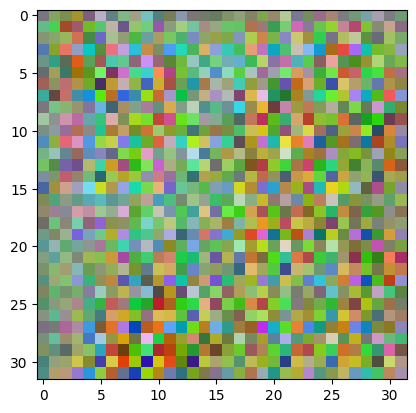

In [32]:
noise = tf.random.normal(shape=(1,100))
random_number = tf.random.uniform(shape=[1,], minval=0, maxval=10, dtype=tf.int32)
test = generator.predict((noise,random_number))
print(random_number)
plt.imshow(test.squeeze())
plt.show()